In [1]:
import re
import pandas as pd
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
FontPath = "C:\\Windows\\Fonts\\meiryo.ttc"
jpfont = FontProperties(fname=FontPath)
from collections import defaultdict, Counter

import MeCab

from sklearn.feature_extraction.text import CountVectorizer

from gensim import corpora, models
from gensim.models import LdaModel, CoherenceModel

import pyLDAvis
from wordcloud import WordCloud

In [2]:
df_all = pd.read_csv("df_last.csv")

for i in range(len(df_all)):
    if df_all["歌詞"][i] == "Not Found...":
        n = df_all.iloc[i,0]
        g = df_all.iloc[i,1]
        a = df_all.iloc[i,3]
        print(f"{n}回"+":"+f"({g})"+a)

2回:(童謡賞)ゆうらんバス_by_水上房子／キング小鳩会
3回:(新人奨励賞)団地のお嬢さん_by_山中みゆき
3回:(新人奨励賞)むすめ三度笠_by_蔵野たつ美
10回:(童謡賞)ペケの歌_by_長谷川よしみ
11回:(童謡賞)うまれたきょうだい１１人_by_スリー・バブルス
13回:(童謡賞)じんじん_by_ひばり児童合唱団
18回:(新人賞)雪ごもり_by_芦川よしみ
34回:(新人賞)今度私どこか連れていって下さいよ_by_加藤紀子
35回:(ミュージックビデオ賞)THE 8TH OF ACE_by_米米CLUB谷村新司


In [3]:
#一曲ずつ
texts = []
for i in range(len(df_all)):
    if df_all["歌詞"][i] != "Not Found..." :
        texts.append(df_all["歌詞"][i])
        
texts = list(dict.fromkeys(texts))

In [21]:
#年ごとに歌詞リスト化
texts = []
t = []
n = 1

for i in range(len(df_all)):
    if df_all["歌詞"][i] != "Not Found..." :
        if df_all["回"][i] == n: #全楽曲
            t.append(df_all["歌詞"][i])
        else:
            t = set(t) #重複削除
            texts.append(t)
            t = [df_all["歌詞"][i]]
            n = df_all["回"][i]
            
        if i == len(df_all)-1:
            texts.append(t)
#平坦化            
for i in range(len(texts)):
    texts[i] = " ".join(texts[i])

In [5]:
#MeCab
def get_words(text):
    #ルビ部分の独立と記号除去
    text = text.replace("！", "!")
    text = text.replace("(", " ").replace(")", " ").replace("!", " ").replace("?", " ")
    text = p.sub('', text)
    
    m = MeCab.Tagger('/usr/local/lib/mecab/dic/mecab-ipadic-neologd/')
    m.parse('') 
    node = m.parseToNode(text)
    word_list = []
    while node:
        pos = node.feature.split(",")[0]
        if pos in ["名詞"]: 
            w = node.surface
            word_list.append(w)
        elif pos in ["動詞", "形容詞"]:
            w = node.feature.split(",")[7]
            if "-" in w:
                w = w.split("-")[0]
            word_list.append(w)
        node = node.next
    
    #小文字化
    li = []
    for w in word_list:
        li.append(w.lower())
    
    #数字消す
    for w in li:
        if w.isdecimal():
            li.remove(w)
            
    #ひらがなカタカタの1文字消す
    for w in li:
        if len(w) == 1:
            if h.fullmatch(w) or k.fullmatch(w):
                li.remove(w)
                
    #ストップワード消す
    delete_words(li, d_li)
    delete_words(li, sloth_li)
    delete_words(li, sloth_lij)
    
    #英語消す
    li = delete_e(li)
    
    return li

In [6]:
def delete_words(li, d_li):
    for w in d_li:
        while w in li:
            li.remove(w)
            
#記号除去            
p = re.compile('[!"#$%&\'\\\\()*+,-./:;<=>?@[\\]^_`{|}~「」〔〕“”〈〉『』【】＆＊・（）＄＃＠。、？！｀＋￥♪％]')

#ひらがなorカタカナ1文字のやつ消す
h = re.compile(r"[\u3041-\u309F]+")
k = re.compile(r'[\u30A1-\u30F4]+')
e = re.compile(r'[a-z]+')

#消したい文字
d_li = [
    "あー", "ああ", "アア", "アアア","みたい","とこ", "ない", "いい", "こと", "よう", "たび", "一", "ーーーア", "あの", "アッ", "あ", "あっ",
    "a","ah","uh","ooh","na", "is","the","from", "i","la","10", "5", 
       ]

#英語消す
def delete_e(li):
    n_li = []
    for w in li:
        if not e.fullmatch(w):
            n_li.append(w)
    return n_li

#ストップワード
#https://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/English.txt
#https://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt
sloth_e = pd.read_table("slothlib_e.txt")
sloth_j = pd.read_table("slothlib_j.txt")
sloth_li = [sloth_e["a"][i] for i in range(len(sloth_e))]
sloth_lij = [sloth_j["あそこ"][i] for i in range(len(sloth_j))]

In [7]:
#単語に分ける
docs = [get_words(i) for i in texts]

In [8]:
#各文書で、出現頻度が1回の単語削除
frequency = defaultdict(int)

for t in  docs:
    for w in t:
        frequency[w] += 1
        
docs = [[w for w in t if frequency[w] > 1] for t in docs]

In [9]:
#辞書化(単語ごとにID振り分け)
dic = corpora.Dictionary(docs)
dic.filter_extremes(no_below=3, no_above=0.7) #3文書以下に出てくるやつ、5割以上の文書に出てくるやつ除外
dic.compactify()
#print(dic.token2id)

In [10]:
#コーパス(bow)
bows = [dic.doc2bow(d) for d in docs]
bows = [sorted(w, key=lambda x:x[1], reverse=True) for w in bows] #降順にする

#コーパス(tf-idf)
tfidf_model = models.TfidfModel(bows, normalize = False)
tfidf = tfidf_model[bows]
tfidf = [sorted(w, key=lambda x:x[1], reverse=True) for w in tfidf] #降順にする

#print(bows[55]) #単語の出現数
#print(tfidf[55]) #単語の出現数と、その単語の他の文書での出現数を加味したやつ
print([[(dic[x[0]], x[1]) for x in w] for w in bows][55]) #単語をそのまま表示
print([[(dic[x[0]], x[1]) for x in w] for w in tfidf][55]) #単語をそのまま表示

[('夜', 3), ('待つ', 2), ('東京', 2), ('仕舞う', 2), ('気まぐれ', 2), ('悲しい', 1), ('涙', 1), ('忘れる', 1), ('泣く', 1), ('言う', 1), ('会う', 1), ('良い', 1), ('成る', 1), ('付く', 1), ('別れる', 1), ('死ぬ', 1), ('灯り', 1), ('酒', 1), ('幸福', 1), ('身', 1), ('横丁', 1), ('逃げる', 1), ('遅い', 1), ('人生', 1), ('他人', 1), ('悩む', 1), ('枯れる', 1)]
[('東京', 12.204476387861478), ('気まぐれ', 11.034551386419162), ('横丁', 7.424166288818101), ('夜', 6.333850000601235), ('悩む', 6.102238193930739), ('遅い', 5.964734670180802), ('待つ', 5.770014955420137), ('仕舞う', 5.770014955420137), ('幸福', 5.616811366760496), ('他人', 5.336703447567761), ('枯れる', 5.336703447567761), ('灯り', 4.780310099043375), ('逃げる', 4.6692787866546315), ('身', 4.336703447567761), ('死ぬ', 4.03184886603934), ('別れる', 3.9323131924884254), ('酒', 3.9006043327610875), ('人生', 3.9006043327610875), ('付く', 3.6428065752934407), ('悲しい', 2.9979015341160022), ('忘れる', 2.39074328728065), ('会う', 2.2244939439817357), ('泣く', 1.9163716486194038), ('涙', 1.7517409468466048), ('良い', 1.730679331318775), ('言う', 1.

In [34]:
s = 667
print(texts[s])
print(docs[s])
bo = [[(dic[x[0]], x[1]) for x in w] for w in bows][s]
ti = [[(dic[x[0]], x[1]) for x in w] for w in tfidf][s]

曲りくねり はしゃいだ道 青葉の森で駆け回る 遊びまわり 日差しの街 誰かが呼んでいる 夏が来る 影が立つ あなたに会いたい 見つけたのはいちばん星 明日も晴れるかな パプリカ 花が咲いたら 晴れた空に種を蒔こう ハレルヤ 夢を描いたなら 心遊ばせあなたにとどけ 雨に燻り 月は陰り 木陰で泣いてたのは誰 一人一人 慰めるように 誰かが呼んでいる 喜びを数えたら あなたでいっぱい 帰り道を照らしたのは 思い出のかげぼうし パプリカ 花が咲いたら 晴れた空に種を蒔こう ハレルヤ 夢を描いたなら 心遊ばせあなたにとどけ 会いに行くよ 並木を抜けて 歌を歌って 手にはいっぱいの 花を抱えて らるらりら パプリカ 花が咲いたら 晴れた空に種を蒔こう ハレルヤ 夢を描いたなら 心遊ばせあなたにとどけ かかと弾ませこの指とまれ
['曲がりくねる', '燥ぐ', '森', '日差し', '街', '呼ぶ', '居る', '来る', '影', '立つ', '会う', '見付ける', '星', '明日', '晴れる', 'パプリカ', '花', '咲く', '晴れる', '空', '種', '蒔く', 'ハレルヤ', '夢', '描く', '心', '遊ばす', '届ける', '雨', '燻る', '泣く', '慰める', '呼ぶ', '居る', '喜び', '数える', '帰り道', '照らす', '思い出', 'かげ', 'パプリカ', '花', '咲く', '晴れる', '空', '種', '蒔く', 'ハレルヤ', '夢', '描く', '心', '遊ばす', '届ける', '会う', '行く', '並木', '抜ける', '歌', '歌う', 'いっぱい', '花', '抱える', 'パプリカ', '花', '咲く', '晴れる', '空', '種', '蒔く', 'ハレルヤ', '夢', '描く', '心', '遊ばす', '届ける', '弾む', '指']


In [35]:
df_b = pd.DataFrame(bo, columns = ["word", "c"])
df_t = pd.DataFrame(ti, columns = ["word", "c"])
c = 12
df_t

,word,c
0,晴れる,20.704955
1,届ける,14.340930
2,描く,14.171180
3,花,11.237826
4,咲く,10.340659
5,日差し,7.839204
6,森,7.424166
7,曲がりくねる,7.424166
8,帰り道,7.424166
9,空,7.375146


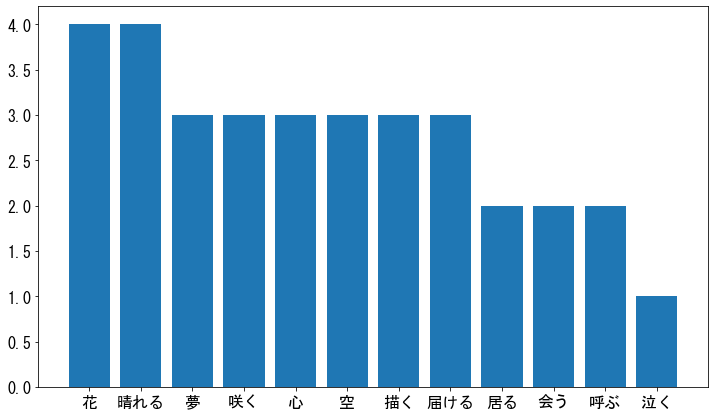

In [36]:
plt.rcParams['font.family'] = "MS Gothic"
plt.rcParams["font.size"] = 16
plt.figure(figsize = (12,7))
plt.bar(df_b.iloc[:c,:]["word"], df_b.iloc[:c,:]["c"])
plt.savefig("corpus_bo.png")

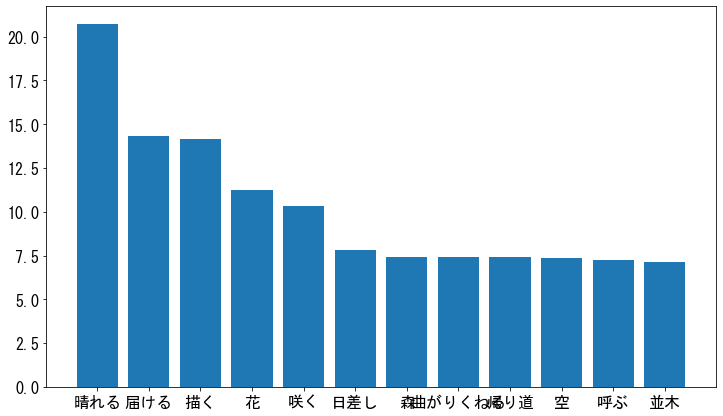

In [37]:
plt.rcParams['font.family'] = "MS Gothic"
plt.rcParams["font.size"] = 16
plt.figure(figsize = (12,7))
plt.bar(df_t.iloc[:c,:]["word"], df_t.iloc[:c,:]["c"])
plt.savefig("corpus_ti.png")